# Create a NLP model for the topics in a given subreddit then train a regression model to predict the popularity and controversiality of a post

## Load packages

In [2]:
import os.path
from os import path
import sys
import ciso8601
import time
import datetime 
import requests
import json
import csv
import praw
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import gensim
import gensim.corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.test.utils import common_corpus
from gensim.test.utils import datapath
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
import sklearn
import sklearn.model_selection as skmodsel
import sklearn.linear_model as sklinmod
import sklearn.ensemble as skensemble
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import multiprocessing as mp
import pickle
import warnings; warnings.simplefilter('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dmartizzi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Experimental: Load data from a pickle file

In [369]:
#subrname = "politicaldiscussion"
#subrname = "history"
#subrname = "quotes"
#subrname = "compsci"
#subrname = "changemyview"
#subrname = "parenting"

#inpath = "./"
#fname = "dump_r-"+subrname+"_2019-09-12.pkl"
inpath = "./subreddit_data/"
fname = inpath+"r-"+subrname+"-export.pkl"
dfraw = pd.read_pickle(fname)

# Filter out removed posts
sel = dfraw["selftext"].str.strip() == "[removed]"
dfraw["selftext"][sel] = ""
dfraw["title+selftext"] = dfraw["title"]+" "+dfraw["selftext"]
dfraw["Popularity"] = dfraw["score"]+dfraw["numComms"]

# Filter out posts with less than 3 words
dfraw["n_words"] = dfraw["title+selftext"][:].str.split()
for i in range(0,len(dfraw["n_words"])):
    dfraw["n_words"][i] = len(dfraw["n_words"][i])

sel = dfraw["n_words"] > 3
df = dfraw[sel]    

df.head(10)


,subreddit,sub_id,title,author,created,url,permalink,score,numComms,flair,selftext,upvote_ratio,title+selftext,Popularity,n_words
0,changemyview,abghnz,CMV: Asian hetero men should die out alone sin...,stupidattraction,2019-01-01 00:12:10,https://www.reddit.com/r/changemyview/comments...,/r/changemyview/comments/abghnz/cmv_asian_hete...,1,0,NaN,,1.00,CMV: Asian hetero men should die out alone sin...,1,11
1,changemyview,abgy7x,"CMV: Affirmative action makes sense in theory,...",showershortz,2019-01-01 01:37:48,https://www.reddit.com/r/changemyview/comments...,/r/changemyview/comments/abgy7x/cmv_affirmativ...,3,8,NaN,I preface this by saying I am from the United ...,0.67,"CMV: Affirmative action makes sense in theory,...",11,222
2,changemyview,abgyqc,CMV: Scientology is a cult and helps no one.,SightWithoutEyes,2019-01-01 01:40:31,https://www.reddit.com/r/changemyview/comments...,/r/changemyview/comments/abgyqc/cmv_scientolog...,2,0,NaN,,0.75,CMV: Scientology is a cult and helps no one.,2,9
3,changemyview,abh0k4,"At 41, I’m finally old enough to appreciate da...",ciciohme2,2019-01-01 01:50:12,https://www.reddit.com/r/changemyview/comments...,/r/changemyview/comments/abh0k4/at_41_im_final...,1,0,NaN,,1.00,"At 41, I’m finally old enough to appreciate da...",1,10
4,changemyview,abh6d6,"CMV: Men not only can live without women, but ...",Bad_Company173,2019-01-01 02:22:27,https://www.reddit.com/r/changemyview/comments...,/r/changemyview/comments/abh6d6/cmv_men_not_on...,0,15,NaN,"In this day and age, being single or celibate-...",0.28,"CMV: Men not only can live without women, but ...",15,802
5,changemyview,abhfsc,CMV: People who earn more should pay less taxe...,eagleye101,2019-01-01 03:11:09,https://www.reddit.com/r/changemyview/comments...,/r/changemyview/comments/abhfsc/cmv_people_who...,0,43,NaN,*Disclosure: I don' consider my self rich alth...,0.29,CMV: People who earn more should pay less taxe...,43,399
6,changemyview,abhglk,CMV: The Left in its present form can't be rec...,VirileMember,2019-01-01 03:15:07,https://www.reddit.com/r/changemyview/comments...,/r/changemyview/comments/abhglk/cmv_the_left_i...,0,60,NaN,As long as the Left defines policies as racist...,0.45,CMV: The Left in its present form can't be rec...,60,116
7,changemyview,abhqys,"CMV: In this post, I am going to offer a funda...",adamski4554,2019-01-01 04:10:21,https://www.reddit.com/r/changemyview/comments...,/r/changemyview/comments/abhqys/cmv_in_this_po...,1,4,NaN,So.\nYou've all heard about the four elements ...,0.57,"CMV: In this post, I am going to offer a funda...",5,689
8,changemyview,abhss0,CMV: You should not have a right to bear arms,blindpacemaker,2019-01-01 04:18:56,https://www.reddit.com/r/changemyview/comments...,/r/changemyview/comments/abhss0/cmv_you_should...,68,394,NaN,\n\nConvince me that you have a good enough r...,0.58,CMV: You should not have a right to bear arms ...,462,794
9,changemyview,abi3yg,I should be about to make suicide joke because...,Bung-Motor,2019-01-01 05:14:59,https://www.reddit.com/r/changemyview/comments...,/r/changemyview/comments/abi3yg/i_should_be_ab...,1,0,NaN,,1.00,I should be about to make suicide joke because...,1,17


## Make plots for the the given subreddit 

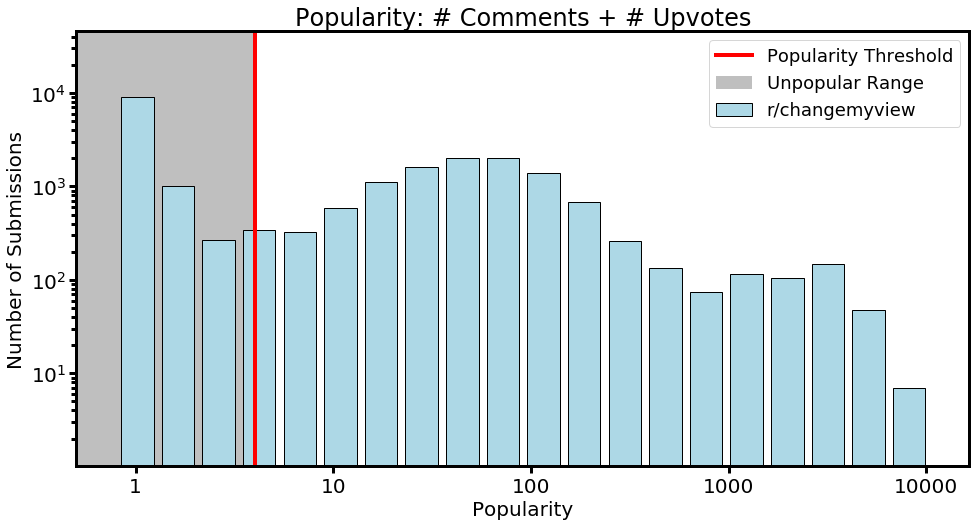

In [370]:
params={'font.size': 20,'axes.labelsize': 20,'legend.fontsize': 18,
        'xtick.labelsize': 20,'ytick.labelsize': 20,'lines.linewidth': 4,'axes.linewidth': 3,
        'xtick.major.width': 3,'ytick.major.width': 3,'xtick.minor.width': 3,'ytick.minor.width': 3,
        'xtick.major.size': 7,'ytick.major.size': 7,'xtick.minor.size': 5,'ytick.minor.size': 5,
        'lines.markeredgewidth' : 3, 'lines.markersize': 6}
mpl.rcParams.update(params)

plt.figure(figsize=(16,8))
plt.xscale("linear")
plt.yscale("log")
xmin = -0.3
xmedian = np.quantile(np.log10(df["Popularity"].values),0.5)
xmax = np.log10(np.max(df["Popularity"].values))
ymin = 1.01
isel = df["Popularity"].values == 1
ymax = 5*len(df["Popularity"].values[isel])
plt.axis([xmin,1.05*xmax,ymin,ymax])
plt.xlabel("Popularity")
plt.ylabel("Number of Submissions")
plt.xticks(np.arange(0,int(1.05*xmax)+1),labels=["%d"%(10**i) for i in np.arange(0,int(1.05*xmax)+1)])
plt.axvspan(-1, xmedian, facecolor='gray',alpha=0.5,label="Unpopular Range")
plt.hist(np.log10(df["Popularity"].values),bins=int((xmax-xmin)*5),range=[xmin,xmax],rwidth=0.8,color='lightblue',edgecolor='black',alpha=1,label="r/"+subrname)
plt.plot([xmedian,xmedian],[ymin,ymax],'r-',label="Popularity Threshold")
plt.title("Popularity: # Comments + # Upvotes")
plt.legend(loc=1)

figoutpath="./pre_rendered_plots"
plt.savefig(figoutpath+"/popularity_hist_r-"+subrname+".png")

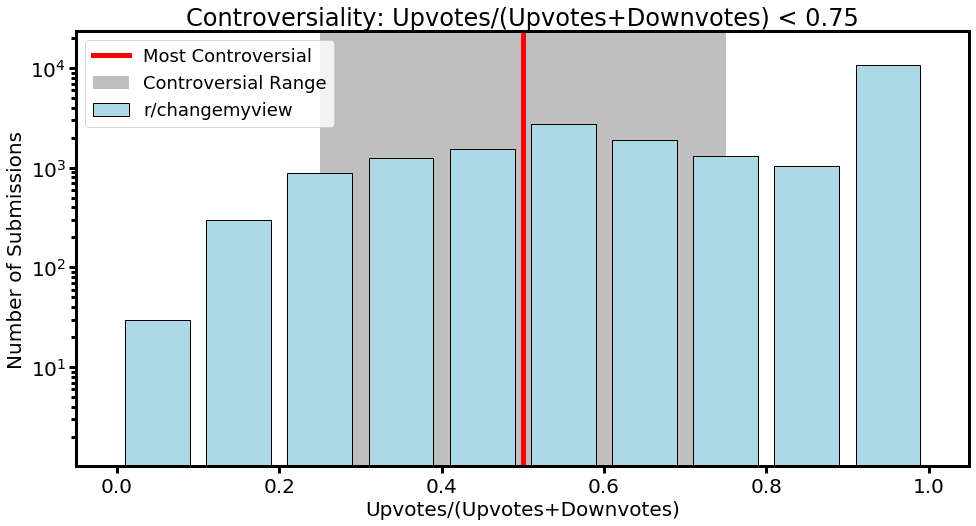

In [371]:
params={'font.size': 20,'axes.labelsize': 20,'legend.fontsize': 18,
        'xtick.labelsize': 20,'ytick.labelsize': 20,'lines.linewidth': 4,'axes.linewidth': 3,
        'xtick.major.width': 3,'ytick.major.width': 3,'xtick.minor.width': 3,'ytick.minor.width': 3,
        'xtick.major.size': 7,'ytick.major.size': 7,'xtick.minor.size': 5,'ytick.minor.size': 5,
        'lines.markeredgewidth' : 3, 'lines.markersize': 6}
mpl.rcParams.update(params)

fig = plt.figure(figsize=(16,8))
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("Upvotes/(Upvotes+Downvotes)")
plt.ylabel("Number of Submissions")
ymin = 1.01
isel = df["upvote_ratio"].values > 0.8
ymax = 2*len(df["upvote_ratio"].values[isel])
plt.axis([-0.05,1.05,ymin,ymax])
plt.xticks(np.arange(0,1.2,0.2),labels=["0.0","0.2","0.4","0.6","0.8","1.0"])
plt.axvspan(0.25, 0.75, facecolor='gray',alpha=0.5,label="Controversial Range")
plt.plot([0.5,0.5],[0,1e8],"r-",linewidth=5,label="Most Controversial")
histdata = [df["upvote_ratio"].values]
plt.hist(histdata,bins=10,range=[0,1],rwidth=0.8,color='lightblue',edgecolor='black',alpha=1,label="r/"+subrname)
plt.title("Controversiality: Upvotes/(Upvotes+Downvotes) < 0.75")
plt.legend(loc=2)

figoutpath="./pre_rendered_plots"
plt.savefig(figoutpath+"/controversiality_hist_r-"+subrname+".png")

## Preprocess the submissions 

In [288]:
def lemmatize_stemming(text):
    '''Function to lemmatize text'''
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [289]:
def preprocess(text):
    '''Function to pre-process text'''
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [290]:
# Preprocess titles 
processed_subm = df["title+selftext"].map(preprocess)

In [291]:
# Create Bag of Words 
dictionary = gensim.corpora.Dictionary(processed_subm)

# Filter out irrelevant words 
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=5000)

# For each tweet, create a dictionary reporting how many
# words and how many times those words appear.
bow_corpus = [dictionary.doc2bow(subm) for subm in processed_subm]

# Experimental: load LDA model or create it if it doesn't exist

In [292]:
if path.exists("lda_models"):
    print("Directory lda_models exists!")
else:
    !mkdir lda_models
    print("Directory lda_models created!")

Directory lda_models exists!


In [293]:
# Choose number of topics for LDA
num_topics_lda = 10

In [294]:
outpath = "./lda_models/"
ldaoutfile = outpath+"lda_model_prod_r-"+subrname
if path.exists(ldaoutfile):
    print(ldaoutfile+"model exists!")
    lda_model = gensim.models.LdaModel.load(ldaoutfile)
else :
    # Create Latent Dirichlet Allocation model with a given number of topics
    ncores = mp.cpu_count()
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=num_topics_lda, id2word=dictionary, \
                passes=10, workers=ncores)
    # Save LDA model to disc (it's expensive to regenerate)
    lda_model.save(ldaoutfile)

./lda_models/lda_model_prod_r-changemyviewmodel exists!


## Perform exploratory data analysis with the LDA model

In [295]:
def get_lda_topics(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20)
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
    return pd.DataFrame(word_dict)

In [296]:
lda_topics_df = get_lda_topics(lda_model, num_topics_lda)
lda_topics_df.head(10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,peopl,women,chang,life,peopl,trump,http,peopl,peopl,peopl
1,like,gender,peopl,human,http,game,reddit,like,white,work
2,thing,peopl,countri,abort,like,like,peopl,think,like,money
3,think,like,human,peopl,media,democrat,vote,want,black,like
4,time,male,world,children,time,time,changemyview,person,think,student
5,chang,think,right,child,drive,presid,state,kill,racist,school
6,food,femal,climat,parent,immigr,countri,polit,know,cultur,colleg
7,year,woman,nigger,think,illeg,support,chang,anim,word,compani
8,want,sexual,think,want,news,http,rule,thing,thing,pay
9,work,person,like,believ,know,peopl,like,right,say,time


In [297]:
# Test LDA model
test_strings = {"test_strings" : list(df["title+selftext"].values)}
df_test_strings = pd.DataFrame(data = test_strings)

# Same procedure as above
processed_test_strings = df_test_strings["test_strings"].map(preprocess)
test_corpus = [dictionary.doc2bow(text) for text in processed_test_strings]
raw = lda_model[test_corpus]
shape = (len(raw),num_topics_lda)
predicted_topic_lda = np.zeros(shape)
for i,tups in enumerate(raw):
    for j in range(0,len(tups)):
        predicted_topic_lda[i,j] = tups[j][1]
    #print(df_test_strings["test_strings"].iloc[i],predicted_topic_lda[i],"\n")

# Experimental: load NMF model or create it if it doesn't exist

In [298]:
if path.exists("nmf_models"):
    print("Directory nmf_models exists!")
else:
    !mkdir nmf_models
    print("Directory nmf_models created!")

Directory nmf_models exists!


In [299]:
# Number of topics for NMF
num_topics_nmf = 10

In [300]:
# Create sentences
processed_subm_sentences = [' '.join(text) for text in processed_subm]

# Word counts
outpath = "./nmf_models/"
outfile = outpath+"count_vectorizer_prod_r-"+subrname
if path.exists(outfile):
    print(outfile+"model exists!")
    vectorizer = pickle.load(open(outfile, 'rb'))    
    x_counts = vectorizer.transform(processed_subm_sentences)
else:
    vectorizer = CountVectorizer(analyzer='word', max_features=5000)
    x_counts = vectorizer.fit_transform(processed_subm_sentences)
    pickle.dump(vectorizer, open(outfile, 'wb'))
    
# TF-IDF transform
outpath = "./nmf_models/"
outfile = outpath+"tfidf_transformer_prod_r-"+subrname
if path.exists(outfile):
    print(outfile+"model exists!")
    transformer = pickle.load(open(outfile, 'rb')) 
    x_tfidf = transformer.transform(x_counts)
else:
    transformer = TfidfTransformer(smooth_idf=True)
    x_tfidf = transformer.fit_transform(x_counts)
    pickle.dump(transformer, open(outfile, 'wb'))

# Normalize to unit length
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

./nmf_models/count_vectorizer_prod_r-changemyviewmodel exists!
./nmf_models/tfidf_transformer_prod_r-changemyviewmodel exists!


In [301]:
outpath = "./nmf_models/"
nmfoutfile = outpath+"nmf_model_prod_r-"+subrname
if path.exists(nmfoutfile):
    print(nmfoutfile+"model exists!")
    nmf_model = pickle.load(open(nmfoutfile, 'rb'))
else :
    # Create NMF model.
    nmf_model = NMF(n_components=num_topics_nmf,init='nndsvd',alpha=0.1)
    # Fit the model
    nmf_model.fit(xtfidf_norm)
    # Save NMF model to disc (it's expensive to regenerate)
    pickle.dump(nmf_model, open(nmfoutfile, 'wb'))

./nmf_models/nmf_model_prod_r-changemyviewmodel exists!


In [302]:
def get_nmf_topics(model, n_top_words, num_topics):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {}
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words
    
    return pd.DataFrame(word_dict)

In [303]:
nmf_topics_df = get_nmf_topics(nmf_model, 10, num_topics_nmf)
nmf_topics_df.head(10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,gender,peopl,abort,better,women,wrong,good,chang,racist,overr
1,transgend,black,murder,dog,right,moral,thing,mind,trump,bread
2,dysphoria,like,legal,cat,equal,kid,evil,view,donald,exist
3,tran,white,illeg,window,attract,incest,world,climat,white,disney
4,femal,shouldn,pregnanc,world,tran,right,vaccin,best,presid,firework
5,exist,think,life,tast,sport,appropri,harm,exist,black,redempt
6,ident,life,child,work,rape,ignor,social,polit,racism,vote
7,male,want,choic,reddit,date,anim,movi,school,wall,best
8,binari,exist,anti,countri,funni,vegan,argument,real,support,song
9,construct,right,right,exist,shallow,scienc,game,need,race,dead


In [304]:
from scipy import sparse

# Test NMF model
test_strings = {"test_strings" : df["title+selftext"].values}
df_test_strings = pd.DataFrame(data = test_strings)

# Same procedure as above
processed_test_strings = df_test_strings["test_strings"].map(preprocess)
test_sentences = [' '.join(text) for text in processed_test_strings]
x_test_counts = vectorizer.transform(test_sentences)
x_test_tfidf = transformer.transform(x_test_counts)
xtfidf_test_norm = normalize(x_test_tfidf, norm='l1', axis=1)
y = nmf_model.transform(xtfidf_test_norm)
predicted_topic_nmf = normalize(y, norm='l1', axis=1)
#for i in range(0,len(predicted_topic_nmf)):
#    print(df_test_strings["test_strings"].iloc[i],predicted_topic_nmf[i])

# Experimental: perform regression to predict popularity and controversiality

## Setup the Popularity and Controversiality 

In [305]:
# Build labels and features

features = predicted_topic_nmf

# Popularity of a post
p = [0] * len(df["Popularity"].values)
popular = np.array(p); del p
cutoff_pop = np.quantile(df["Popularity"].values,q=0.5)
selp0 = df["Popularity"].values > cutoff_pop
popular[selp0] = 1

# Controversiality of a post
c = [0] * len(df["upvote_ratio"].values)
controversial = np.array(c); del c
inf = 0.25
sup = 0.75
selc0 = np.logical_and(inf <= df["upvote_ratio"].values.astype(float), \
                       df["upvote_ratio"].values.astype(float) <= sup)
controversial[selc0] = 1
selc1 = np.logical_or(df["upvote_ratio"].values.astype(float) < inf, \
                      df["upvote_ratio"].values.astype(float) > sup)

Fpop = float(len(popular[selp0])/len(popular))
Fcon = float(len(controversial[selc0])/len(controversial))

print("Fraction of Popular Posts = ",float(len(popular[selp0])/len(popular)))
print("Fraction of Controversial Posts = ",float(len(controversial[selc0])/len(controversial)))

Fraction of Popular Posts =  0.49576777992455606
Fraction of Controversial Posts =  0.4068911583402337


## Split in training, testing and validation sets

In [306]:
test_size = 0.2
validation_size = 0.2
train_size = 1.0 - test_size - validation_size

X, featurep_test, Y, popular_test = \
    skmodsel.train_test_split(features,popular,test_size=test_size,stratify=popular)
featurep_train, featurep_validation, popular_train, popular_validation = \
    skmodsel.train_test_split(X,Y,test_size=validation_size/(1.0-test_size),stratify=Y)

X, featurec_test, Y, controversial_test = \
    skmodsel.train_test_split(features,controversial,test_size=test_size,stratify=controversial)
featurec_train, featurec_validation, controversial_train, controversial_validation = \
    skmodsel.train_test_split(X,Y,test_size=validation_size/(1.0-test_size),stratify=Y)

del X,Y

## Create and train Logistic Regression models

These models are robust but do not achieve top precision.

In [307]:
wp = [1.0] * featurep_train.shape[0]
weight_pop = np.array(wp); del wp
selp0 = weight_pop == 0
weight_pop[selp0] = Fpop
#weight_pop = {0: Fpop, 1: 1.0}

wc = [1.0] * featurec_train.shape[0]
weight_con = np.array(wc); del wc
selc1 = weight_con == 0
weight_con[selc1] = Fcon
#weight_pop = {0: Fcon, 1: 1.0}

popular_logregmodel = sklinmod.LogisticRegression()
controversial_logregmodel = sklinmod.LogisticRegression()
popular_logregmodel = popular_logregmodel.fit(featurep_train,popular_train, \
                            sample_weight=weight_pop)
controversial_logregmodel = controversial_logregmodel.fit(featurec_train,controversial_train, \
                            sample_weight=weight_con)

pred_pop_train = popular_logregmodel.predict(featurep_train)
pred_pop_test = popular_logregmodel.predict(featurep_test)
pred_pop_val = popular_logregmodel.predict(featurep_validation)
pred_con_train = popular_logregmodel.predict(featurec_train)
pred_con_test = popular_logregmodel.predict(featurec_test)
pred_con_val = popular_logregmodel.predict(featurec_validation)

prec_pop_train = sklearn.metrics.precision_score(popular_train,pred_pop_train)
prec_pop_test = sklearn.metrics.precision_score(popular_test,pred_pop_test)
prec_pop_val = sklearn.metrics.precision_score(popular_validation,pred_pop_val)
prec_con_train = sklearn.metrics.precision_score(controversial_train,pred_con_train)
prec_con_test = sklearn.metrics.precision_score(controversial_test,pred_con_test)
prec_con_val = sklearn.metrics.precision_score(controversial_validation,pred_con_val)

print("Logistic regression for Popularity. Score on Training Set = ", prec_pop_train)
print("Logistic regression for Popularity. Score on Test Set = ", prec_pop_test)
print("Logistic regression for Popularity. Score on Validation Set = ", prec_pop_val,"\n")

print("Logistic regression for Controversiality. Score on Training Set = ", prec_con_train)
print("Logistic regression for Controversiality. Score on Training Set = ", prec_con_test)
print("Logistic regression for Controversiality. Score on Training Set = ", prec_con_val,"\n")

outpath = "./regression_models/"
outname = outpath+"lorgreg_scores_nmf_prod_r-"+subrname+".csv"
with open(outname, 'w') as csvfile:
    writer = csv.writer(csvfile,delimiter=",")
    writer.writerow(["PopTraniningScore", "PopTestScore", "PopValidationScore", \
                    "ConTraniningScore", "ConTestScore", "ConValidationScore", 
                    "PopFraction","ConFraction"])
    writer.writerow([str(prec_pop_train), \
                    str(prec_pop_test), \
                    str(prec_pop_val), \
                    str(prec_con_train), \
                    str(prec_con_test), \
                    str(prec_con_val), \
                    str(Fpop),str(Fcon)])

scores = pd.read_csv(outname)
display(scores)

Logistic regression for Popularity. Score on Training Set =  0.540258711721225
Logistic regression for Popularity. Score on Test Set =  0.5503753457131568
Logistic regression for Popularity. Score on Validation Set =  0.535483870967742 

Logistic regression for Controversiality. Score on Training Set =  0.4301602012445386
Logistic regression for Controversiality. Score on Training Set =  0.43251902282739285
Logistic regression for Controversiality. Score on Training Set =  0.43713046905794245 



,PopTraniningScore,PopTestScore,PopValidationScore,ConTraniningScore,ConTestScore,ConValidationScore,PopFraction,ConFraction
0,0.540259,0.550375,0.535484,0.43016,0.432519,0.43713,0.495768,0.406891


## Save Logistic Regression models

In [308]:
# Save regression model to disc 
outpath = "./regression_models/"
fname = outpath+"logreg_popular_from_nmf_prod_r-"+subrname
pickle.dump(popular_logregmodel, open(fname, 'wb'))
fname = outpath+"logreg_controversial_from_nmf_prod_r-"+subrname
pickle.dump(controversial_logregmodel, open(fname, 'wb'))

## Create and train Random Forests models

These models seem to overfit.

In [312]:
popular_rforestmodel = skensemble.RandomForestRegressor( \
                        n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
controversial_rforestmodel = skensemble.RandomForestRegressor( \
                        n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

popular_rforestmodel = popular_rforestmodel.fit(featurep_train,popular_train, \
                       sample_weight=weight_pop)
controversial_rforestmodel = controversial_rforestmodel.fit(featurec_train,controversial_train, \
                             sample_weight=weight_con)

pred_pop_train = np.rint(popular_rforestmodel.predict(featurep_train))
pred_pop_test = np.rint(popular_rforestmodel.predict(featurep_test))
pred_pop_val = np.rint(popular_rforestmodel.predict(featurep_validation))
pred_con_train = np.rint(popular_rforestmodel.predict(featurec_train))
pred_con_test = np.rint(popular_rforestmodel.predict(featurec_test))
pred_con_val = np.rint(popular_rforestmodel.predict(featurec_validation))

prec_pop_train = sklearn.metrics.precision_score(popular_train,pred_pop_train)
prec_pop_test = sklearn.metrics.precision_score(popular_test,pred_pop_test)
prec_pop_val = sklearn.metrics.precision_score(popular_validation,pred_pop_val)
prec_con_train = sklearn.metrics.precision_score(controversial_train,pred_con_train)
prec_con_test = sklearn.metrics.precision_score(controversial_test,pred_con_test)
prec_con_val = sklearn.metrics.precision_score(controversial_validation,pred_con_val)

print("Random Forest for Popularity. Score on Training Set = ", prec_pop_train)
print("Random Forest for Popularity. Score on Test Set = ", prec_pop_test)
print("Random Forest for Popularity. Score on Validation Set = ", prec_pop_val,"\n")

print("Random Forest for Controversiality. Score on Training Set = ", prec_con_train)
print("Random Forest for Controversiality. Score on Training Set = ", prec_con_test)
print("Random Forest for Controversiality. Score on Training Set = ", prec_con_val,"\n")

outpath = "./regression_models/"
outname = outpath+"rforest_scores_nmf_prod_r-"+subrname+".csv"
with open(outname, 'w') as csvfile:
    writer = csv.writer(csvfile,delimiter=",")
    writer.writerow(["PopTraniningScore", "PopTestScore", "PopValidationScore", \
                    "ConTraniningScore", "ConTestScore", "ConValidationScore", 
                    "PopFraction","ConFraction"])
    writer.writerow([str(prec_pop_train), \
                    str(prec_pop_test), \
                    str(prec_pop_val), \
                    str(prec_con_train), \
                    str(prec_con_test), \
                    str(prec_con_val), \
                    str(Fpop),str(Fcon)])

Random Forest for Popularity. Score on Training Set =  0.9863144493952897
Random Forest for Popularity. Score on Test Set =  0.7311099531005733
Random Forest for Popularity. Score on Validation Set =  0.7206396801599201 

Random Forest for Controversiality. Score on Training Set =  0.6743996079072047
Random Forest for Controversiality. Score on Training Set =  0.6771964461994077
Random Forest for Controversiality. Score on Training Set =  0.6835196888672824 



## Create and train Gradient Boosting models

These models are robust and achieve best precision.

In [320]:
popular_gboost = skensemble.GradientBoostingRegressor( \
                        n_estimators=200, learning_rate=0.1, random_state=0)
controversial_gboost = skensemble.GradientBoostingRegressor( \
                        n_estimators=200, learning_rate=0.1, random_state=0)

popular_gboost = popular_gboost.fit(featurep_train,popular_train, \
                       sample_weight=weight_pop)
controversial_gboost = controversial_gboost.fit(featurec_train,controversial_train, \
                       sample_weight=weight_con)

pred_pop_train = np.rint(popular_gboost.predict(featurep_train))
pred_pop_test = np.rint(popular_gboost.predict(featurep_test))
pred_pop_val = np.rint(popular_gboost.predict(featurep_validation))
pred_con_train = np.rint(popular_gboost.predict(featurec_train))
pred_con_test = np.rint(popular_gboost.predict(featurec_test))
pred_con_val = np.rint(popular_gboost.predict(featurec_validation))

prec_pop_train = sklearn.metrics.precision_score(popular_train,pred_pop_train)
prec_pop_test = sklearn.metrics.precision_score(popular_test,pred_pop_test)
prec_pop_val = sklearn.metrics.precision_score(popular_validation,pred_pop_val)
prec_con_train = sklearn.metrics.precision_score(controversial_train,pred_con_train)
prec_con_test = sklearn.metrics.precision_score(controversial_test,pred_con_test)
prec_con_val = sklearn.metrics.precision_score(controversial_validation,pred_con_val)

print("Gradient Boost for Popularity. Score on Training Set = ", prec_pop_train)
print("Gradient Boost for Popularity. Score on Test Set = ", prec_pop_test)
print("Gradient Boost for Popularity. Score on Validation Set = ", prec_pop_val,"\n")

print("Gradient Boost for Controversiality. Score on Training Set = ", prec_con_train)
print("Gradient Boost for Controversiality. Score on Training Set = ", prec_con_test)
print("Gradient Boost for Controversiality. Score on Training Set = ", prec_con_val,"\n")

outpath = "./regression_models/"
outname = outpath+"gboost_scores_nmf_prod_r-"+subrname+".csv"
with open(outname, 'w') as csvfile:
    writer = csv.writer(csvfile,delimiter=",")
    writer.writerow(["PopTraniningScore", "PopTestScore", "PopValidationScore", \
                    "ConTraniningScore", "ConTestScore", "ConValidationScore", 
                    "PopFraction","ConFraction"])
    writer.writerow([str(prec_pop_train), \
                    str(prec_pop_test), \
                    str(prec_pop_val), \
                    str(prec_con_train), \
                    str(prec_con_test), \
                    str(prec_con_val), \
                    str(Fpop),str(Fcon)])

Gradient Boost for Popularity. Score on Training Set =  0.7685900348326519
Gradient Boost for Popularity. Score on Test Set =  0.753576372865713
Gradient Boost for Popularity. Score on Validation Set =  0.7328552218735993 

Gradient Boost for Controversiality. Score on Training Set =  0.6017658699954331
Gradient Boost for Controversiality. Score on Training Set =  0.5940727436012573
Gradient Boost for Controversiality. Score on Training Set =  0.5959183673469388 



# Production model creation and optimization 

The full pipeline is run multiple times assuming different numbers of topics, then the best model in terms of compromise between precision and robustness is selected as the production model.

In [48]:
if path.exists("nmf_models"):
    print("Directory nmf_models exists!")
else:
    !mkdir nmf_models
    print("Directory nmf_models created!")
    
if path.exists("regression_models"):
    print("Directory regression_models exists!")
else:
    !mkdir regression_models
    print("Directory regression_models created!")
    
if path.exists("pre_rendered_plots"):
    print("Directory pre_rendered_plots exists!")
else:
    !mkdir regression_models
    print("Directory pre_rendered_plots created!")
    

Directory nmf_models exists!
Directory regression_models exists!
Directory pre_rendered_plots exists!


In [49]:
def lemmatize_stemming(text):
    '''Function to lemmatize text'''
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [50]:
def preprocess(text):
    '''Function to pre-process text'''
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [51]:
def create_models(processed_subm_sentences,num_topics):
    '''
    This function runs the whole pipeline to train 
    the NMF topic model and the regression models for
    popularity and controversiality.
    '''
    # NMF model
    vectorizer = CountVectorizer(analyzer='word', max_features=5000)
    x_counts = vectorizer.fit_transform(processed_subm_sentences)
    transformer = TfidfTransformer(smooth_idf=True)
    x_tfidf = transformer.fit_transform(x_counts)
    xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)
    nmf_model = NMF(n_components=num_topics,init='nndsvd',alpha=0.1)
    y = nmf_model.fit_transform(xtfidf_norm)
    features = normalize(y, norm='l1', axis=1)
    
    # Popularity of a post
    p = [0] * len(df["Popularity"].values)
    popular = np.array(p); del p
    cutoff_pop = np.quantile(df["Popularity"].values,q=0.5)
    selp0 = df["Popularity"].values > cutoff_pop
    popular[selp0] = 1

    # Controversiality of a post
    c = [0] * len(df["upvote_ratio"].values)
    controversial = np.array(c); del c
    inf = 0.25
    sup = 0.75
    selc0 = np.logical_and(inf <= df["upvote_ratio"].values.astype(float), \
                       df["upvote_ratio"].values.astype(float) <= sup)
    controversial[selc0] = 1
    
    # Fraction of popular and controversial
    Fpop = float(len(popular[selp0])/len(popular))
    Fcon = float(len(controversial[selc0])/len(controversial))
    
    # Training/Test/Validation
    test_size = 0.2
    validation_size = 0.2
    train_size = 1.0 - test_size - validation_size
    X, featurep_test, Y, popular_test = \
        skmodsel.train_test_split(features,popular,test_size=test_size,stratify=popular)
    featurep_train, featurep_validation, popular_train, popular_validation = \
        skmodsel.train_test_split(X,Y,test_size=validation_size/(1.0-test_size),stratify=Y)
    X, featurec_test, Y, controversial_test = \
        skmodsel.train_test_split(features,controversial,test_size=test_size,stratify=controversial)
    featurec_train, featurec_validation, controversial_train, controversial_validation = \
        skmodsel.train_test_split(X,Y,test_size=validation_size/(1.0-test_size),stratify=Y)
    del X,Y
    
    # Sample Weights
    wp = [1.0] * featurep_train.shape[0]
    weight_pop = np.array(wp); del wp
    selp0 = weight_pop == 0
    weight_pop[selp0] == Fpop

    wc = [1.0] * featurec_train.shape[0]
    weight_con = np.array(wc); del wc
    selc1 = weight_con == 0
    weight_con[selc1] = Fcon

    #
    popular_gboost = skensemble.GradientBoostingRegressor( \
                     n_estimators=100, learning_rate=0.1, random_state=0)
    controversial_gboost = skensemble.GradientBoostingRegressor( \
                     n_estimators=100, learning_rate=0.1, random_state=0)

    popular_gboost = popular_gboost.fit(featurep_train,popular_train, \
                     sample_weight=weight_pop)
    controversial_gboost = controversial_gboost.fit(featurec_train,controversial_train, \
                     sample_weight=weight_con)

    pred_pop_train = np.rint(popular_gboost.predict(featurep_train))
    pred_pop_test = np.rint(popular_gboost.predict(featurep_test))
    pred_pop_val = np.rint(popular_gboost.predict(featurep_validation))
    pred_con_train = np.rint(popular_gboost.predict(featurec_train))
    pred_con_test = np.rint(popular_gboost.predict(featurec_test))
    pred_con_val = np.rint(popular_gboost.predict(featurec_validation))

    prec_pop_train = sklearn.metrics.precision_score(popular_train,pred_pop_train)
    prec_pop_test = sklearn.metrics.precision_score(popular_test,pred_pop_test)
    prec_pop_val = sklearn.metrics.precision_score(popular_validation,pred_pop_val)
    prec_con_train = sklearn.metrics.precision_score(controversial_train,pred_con_train)
    prec_con_test = sklearn.metrics.precision_score(controversial_test,pred_con_test)
    prec_con_val = sklearn.metrics.precision_score(controversial_validation,pred_con_val)
    
    return vectorizer,transformer,nmf_model, \
           popular_gboost, \
           prec_pop_train,prec_pop_test,prec_pop_val, \
           controversial_gboost, \
           prec_con_train,prec_con_test,prec_con_val,Fpop,Fcon     

In [52]:
def save_models(subr,sel_num_topics,vectorizer,transformer,nmf_model, \
                gb_popular,gb_controversial,precision_pop,precision_con, \
                Fcon,Fpop):

    # Save Topic Model
    outpath = "./nmf_models"
    outfile = outpath+"/count_vectorizer_prod_r-"+subr
    pickle.dump(vectorizer, open(outfile, 'wb'))
    outfile = outpath+"/tfidf_transformer_prod_r-"+subr
    pickle.dump(transformer, open(outfile, 'wb'))    
    outfile = outpath+"/nmf_model_prod_r-"+subr
    pickle.dump(nmf_model, open(outfile, 'wb'))

    # Save Regression Model
    outpath = "./regression_models"
    outfile = outpath+"/gbreg_popular_prod_r-"+subr
    pickle.dump(gb_popular, open(outfile, 'wb'))
    outfile = outpath+"/gbreg_controversial_prod_r-"+subr
    pickle.dump(gb_controversial, open(outfile, 'wb'))
    
    # Save Precisions and Fractions
    outpath = "./regression_models"
    outfile = outpath+"/gbprecision_nmf_prod_r-"+subr+".csv"
    with open(outfile, 'w') as csvfile:
        writer = csv.writer(csvfile,delimiter=",")
        writer.writerow(["PopTraniningScore", "PopTestScore", "PopValidationScore", \
                    "ConTraniningScore", "ConTestScore", "ConValidationScore", 
                    "PopFraction","ConFraction"])
        writer.writerow([str(precision_pop[0]), \
                         str(precision_pop[1]), \
                         str(precision_pop[2]), \
                         str(precision_con[0]), \
                         str(precision_con[1]), \
                         str(precision_con[2]), \
                         str(Fpop),str(Fcon)])
    

In [53]:
def plot_precision(subr,sel_num_topics,num_topics_list,prec_matrix):
    params={'font.size': 20,'axes.labelsize': 20,'legend.fontsize': 18,
            'xtick.labelsize': 20,'ytick.labelsize': 20,'lines.linewidth': 4,'axes.linewidth': 3,
            'xtick.major.width': 3,'ytick.major.width': 3,'xtick.minor.width': 3,'ytick.minor.width': 3,
            'xtick.major.size': 7,'ytick.major.size': 7,'xtick.minor.size': 5,'ytick.minor.size': 5,
            'lines.markeredgewidth' : 3, 'lines.markersize': 6}
    mpl.rcParams.update(params)

    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.xlabel("Number of Topics")
    plt.ylabel("Precision")
    plt.axis([0,101,0.0,1.0])
    plt.title("GBoosting on Popolarity")
    plt.plot(num_topics_list,prec_matrix[:,0,0],label="r/"+subr+" Training Set")
    plt.plot(num_topics_list,prec_matrix[:,0,1],label="r/"+subr+" Test Set")
    plt.plot(num_topics_list,prec_matrix[:,0,2],label="r/"+subr+" Validation Set")
    plt.plot([sel_num_topics,sel_num_topics],[0.35,2],'r-',label="Selected Model")
    plt.legend(loc=4)
    plt.subplot(122)
    plt.xlabel("Number of Topics")
    plt.ylabel("Precision")
    plt.axis([0,101,0.0,1.0])
    plt.title("GBoosting on Controversiality")
    plt.plot(num_topics_list,prec_matrix[:,1,0],label="r/"+subr+" Training Set")
    plt.plot(num_topics_list,prec_matrix[:,1,1],label="r/"+subr+" Test Set")
    plt.plot(num_topics_list,prec_matrix[:,1,2],label="r/"+subr+" Validation Set")
    plt.plot([sel_num_topics,sel_num_topics],[0.35,2],'r-',label="Selected Model")
    #plt.legend(loc=3)
    plt.savefig("./pre_rendered_plots/precision_r-"+subr+".png")
    

In [54]:
def plot_popularity(subr,df):
    plt.figure(figsize=(16,8))
    plt.xscale("linear")
    plt.yscale("log")
    xmin = -0.3
    xmedian = np.quantile(np.log10(df["Popularity"].values),0.5)
    xmax = np.log10(np.max(df["Popularity"].values))
    ymin = 1.01
    isel = df["Popularity"].values == 1
    ymax = 5*len(df["Popularity"].values[isel])
    plt.axis([xmin,1.05*xmax,ymin,ymax])
    plt.xlabel("Popularity")
    plt.ylabel("Number of Submissions")
    plt.xticks(np.arange(0,int(1.05*xmax)+1),labels=["%d"%(10**i) for i in np.arange(0,int(1.05*xmax)+1)])
    plt.axvspan(-1, xmedian, facecolor='gray',alpha=0.5,label="Unpopular Range")
    plt.hist(np.log10(df["Popularity"].values),bins=int((xmax-xmin)*5),range=[xmin,xmax],rwidth=0.8,color='lightblue',edgecolor='black',alpha=1,label="r/"+subr)
    plt.plot([xmedian,xmedian],[ymin,ymax],'r-',label="Popularity Threshold")
    plt.title("Popularity = #Comments + #Upvotes")
    plt.legend(loc=1)
    plt.savefig("./pre_rendered_plots/popularity_hist_r-"+subr+".png")
    

In [61]:
def plot_controversiality(subr,df):
    fig = plt.figure(figsize=(16,8))
    plt.xscale("linear")
    plt.yscale("log")
    plt.xlabel("Controversiality")
    plt.ylabel("Number of Submissions")
    ymin = 1.01
    isel = df["Controversiality"].values < 0.2
    ymax = 5.*len(df["Controversiality"].values[isel])
    plt.axis([-0.01,1.0,ymin,ymax])
    plt.xticks(np.arange(0,1.2,0.2),labels=["0.0","0.2","0.4","0.6","0.8","1.0"])
    plt.axvspan(0.5, 1.0, facecolor='gray',alpha=0.5,label="Controversial Range")
    plt.plot([0.5,0.5],[0,1e8],"r-",linewidth=5,label="Controversiality Threshold")
    histdata = [df["Controversiality"].values]
    plt.hist(histdata,bins=20,range=[0,1],rwidth=0.8,color='lightblue',edgecolor='black',alpha=1,label="r/"+subr)
    plt.title("Controversiality = 1-|2*#Upvotes/(#Upvotes+#Downvotes)-1|")
    plt.legend(loc=1)
    plt.savefig("./pre_rendered_plots/controversiality_hist_r-"+subr+".png")
    

In [62]:
def optimal_model(subr,df,incr_thr,diff_thr):
    '''
    This function finds the optimal model that 
    does not overfit the data and for which 
    precision maximized. 
    '''    
    # Preprocess titles 
    processed_subm = df["title+selftext"].map(preprocess)
    processed_subm_sentences = [' '.join(text) for text in processed_subm]

    # Storage structures for the models
    num_topics_list = [2,5,10,20,30,40,50,60,70,80,90,100]
    prec_matrix = np.zeros((len(num_topics_list),2,3))
    old_prec_pop_train = 0.01
    old_prec_con_train = 0.01
    increment_pop_train = 0.0
    increment_con_train = 0.0
    diff_pop = 0.0
    diff_con = 0.0
    sel_num_topics = 0
    selected = False
    for i,num_topics in enumerate(num_topics_list):
        vec,trans,nmf, \
        gbpop,prec_pop_train, \
        prec_pop_test,prec_pop_val, \
        gbcon,prec_con_train, \
        prec_con_test,prec_con_val, \
        Fpop,Fcon = create_models(processed_subm_sentences,num_topics)
    
        # Precision Matrix 
        prec_matrix[i,0,0] = prec_pop_train
        prec_matrix[i,0,1] = prec_pop_test
        prec_matrix[i,0,2] = prec_pop_val
        prec_matrix[i,1,0] = prec_con_train
        prec_matrix[i,1,1] = prec_con_test
        prec_matrix[i,1,2] = prec_con_val  

        # Precision relative increment
        increment_pop_train = (prec_pop_train-old_prec_pop_train)/old_prec_pop_train
        increment_con_train = (prec_con_train-old_prec_con_train)/old_prec_con_train
    
        # Relative ifference between training and test/validation test
        diff_pop = (prec_pop_train-0.5*(prec_pop_test+prec_pop_val))/prec_pop_train
        diff_con = (prec_con_train-0.5*(prec_con_test+prec_con_val))/prec_con_train   
    
        # Update old precisions
        old_prec_pop_train = prec_pop_train
        old_prec_con_train = prec_con_train

        # Selec model
        if increment_pop_train > incr_thr and increment_con_train > incr_thr and \
            diff_pop < diff_thr and diff_con < diff_thr:
        
            sel_num_topics = num_topics
            vectorizer = vec
            transformer = trans
            nmf_model = nmf
            gb_popular = gbpop
            gb_controversial = gbcon
            precision_pop = [prec_pop_train,prec_pop_test,prec_pop_test]
            precision_con = [prec_con_train,prec_con_test,prec_con_val]
            selected = True
    
    try:
        save_models(subr,sel_num_topics,vectorizer,transformer,nmf_model, \
                    gb_popular,gb_controversial,precision_pop,precision_con, \
                    Fpop,Fcon)
    except:
        print("Unable to select a good model...")
    
    plot_precision(subr,sel_num_topics,num_topics_list,prec_matrix)
    plot_popularity(subr,df)
    plot_controversiality(subr,df)
    
    return selected

In [63]:
def load_subr(subr):
    inpath = "./subreddit_data/"
    fname = inpath+"r-"+subr+"-export.pkl"
    dfraw = pd.read_pickle(fname)

    # Filter out removed posts
    sel = dfraw["selftext"].str.strip() == "[removed]"
    dfraw["selftext"][sel] = ""
    dfraw["title+selftext"] = dfraw["title"]+" "+dfraw["selftext"]
    dfraw["Popularity"] = dfraw["score"]+dfraw["numComms"]
    dfraw["Controversiality"] = 1.0-np.abs((dfraw["upvote_ratio"].values.astype(float)-0.5)/0.5)
    
    
    # Filter out posts with less than 3 words
    dfraw["n_words"] = dfraw["title+selftext"][:].str.split()
    for i in range(0,len(dfraw["n_words"])):
        dfraw["n_words"][i] = len(dfraw["n_words"][i])
    sel = dfraw["n_words"] > 3
    df = dfraw[sel]  
    
    return df

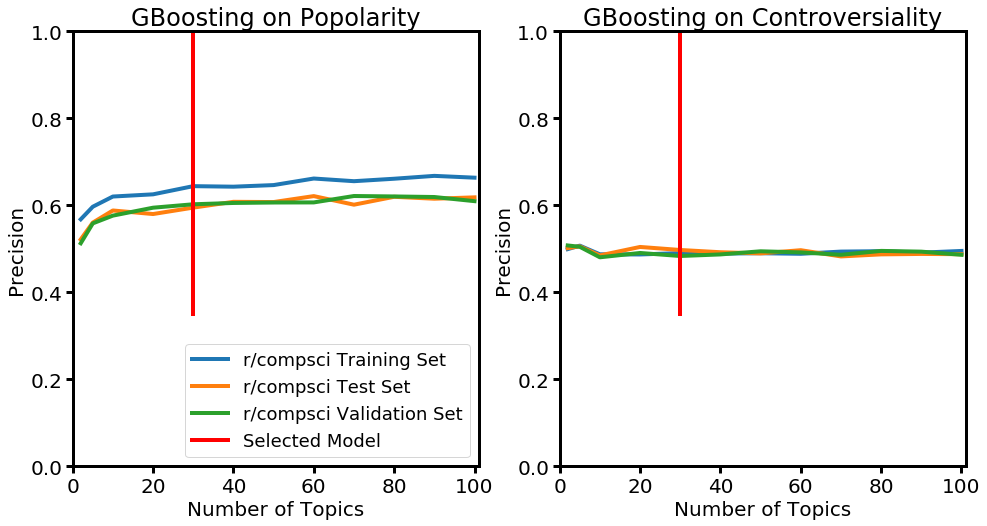

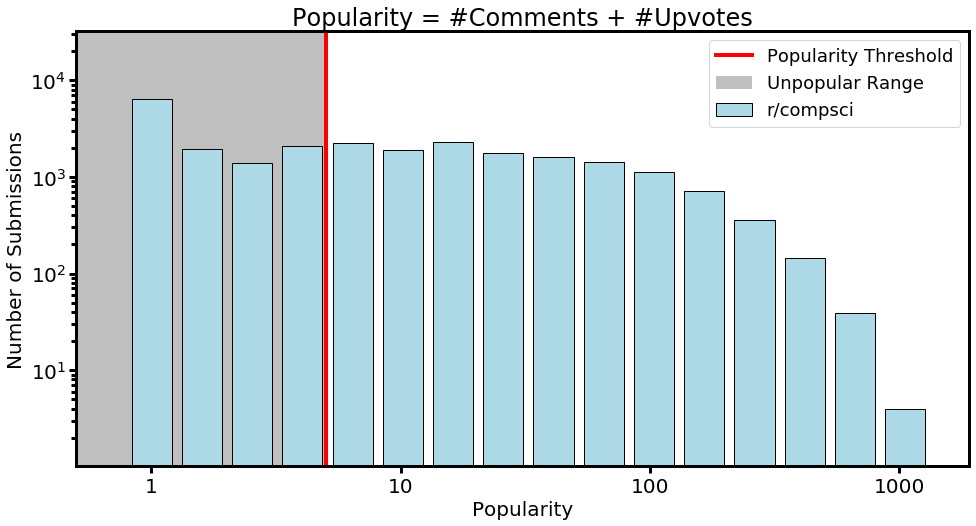

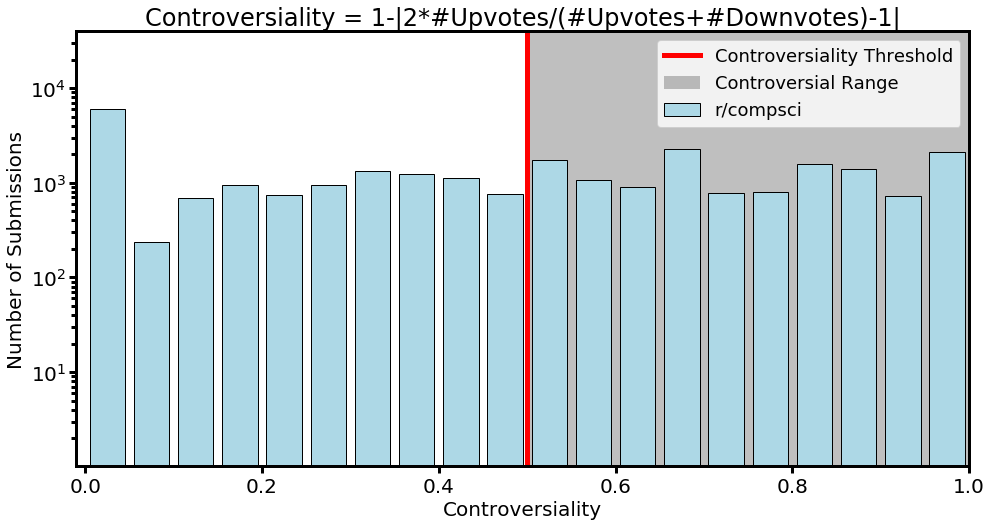

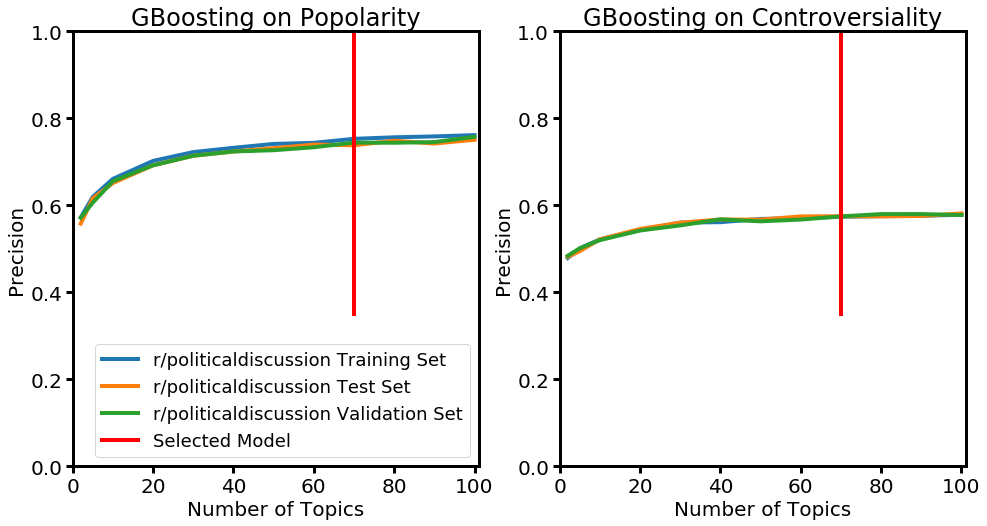

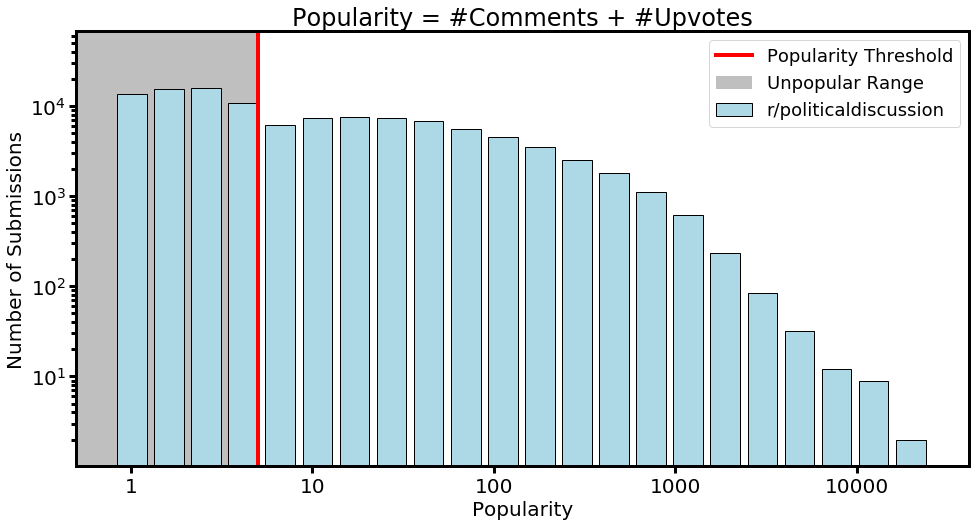

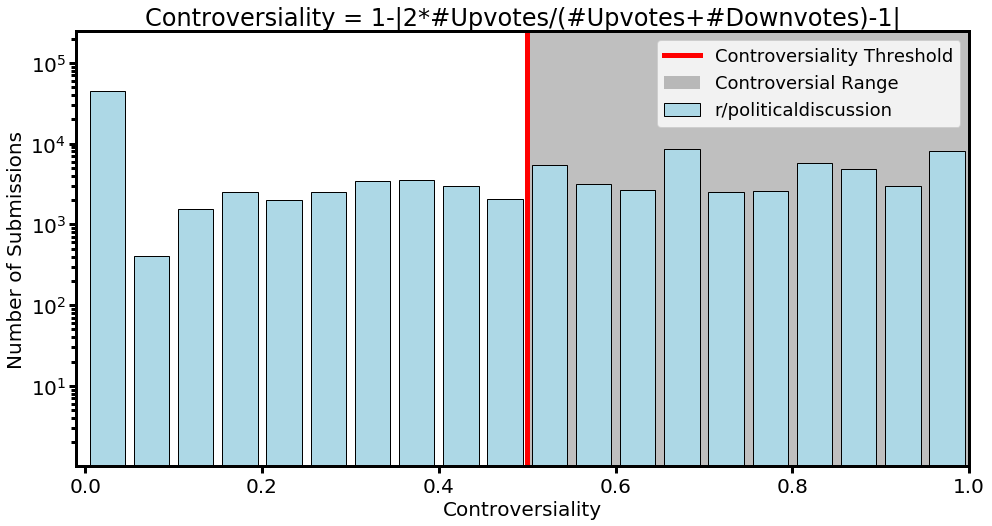

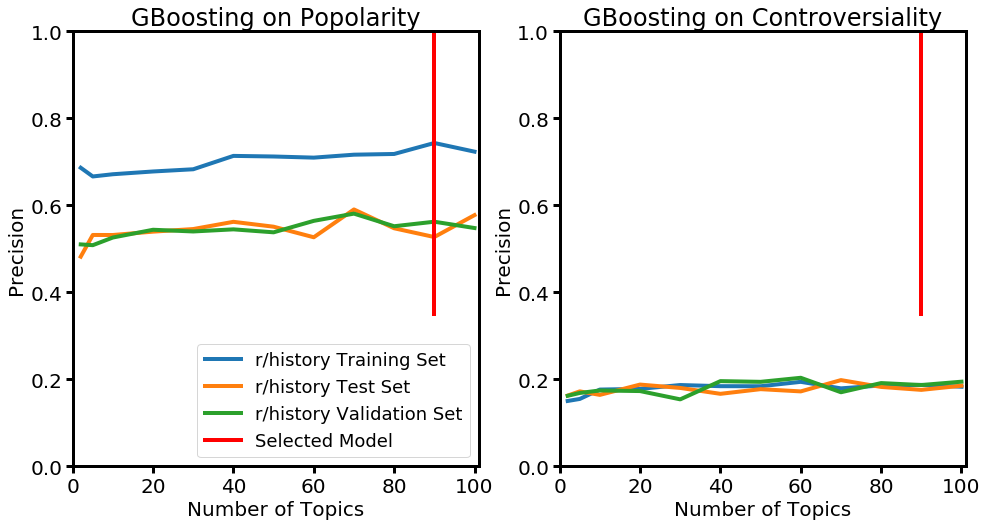

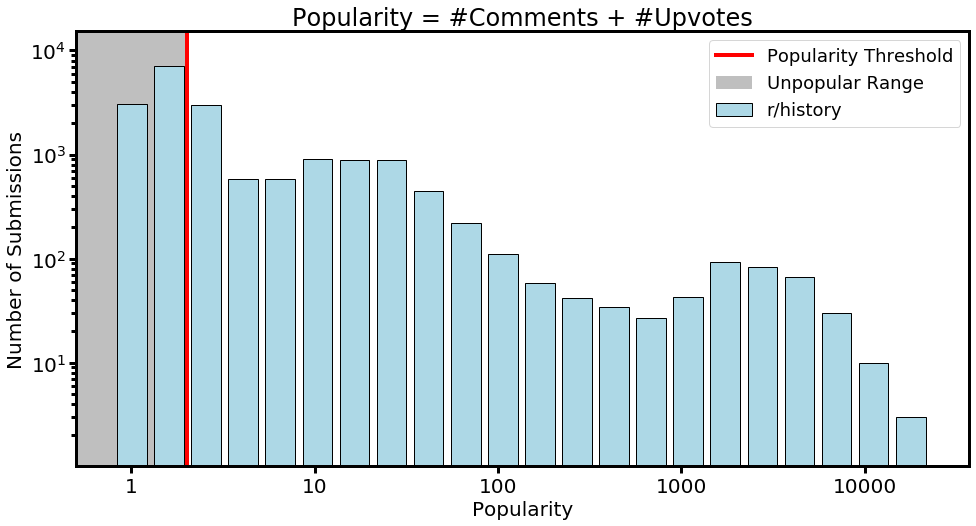

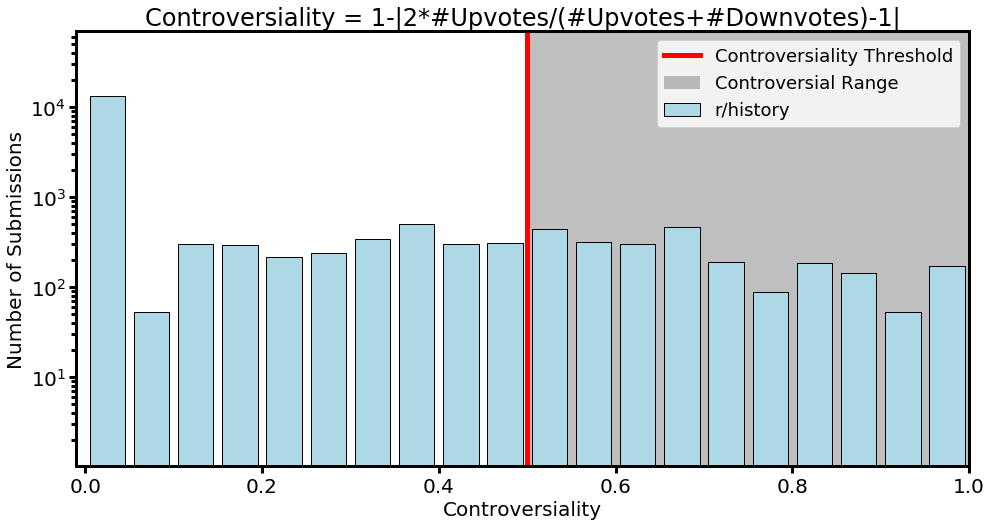

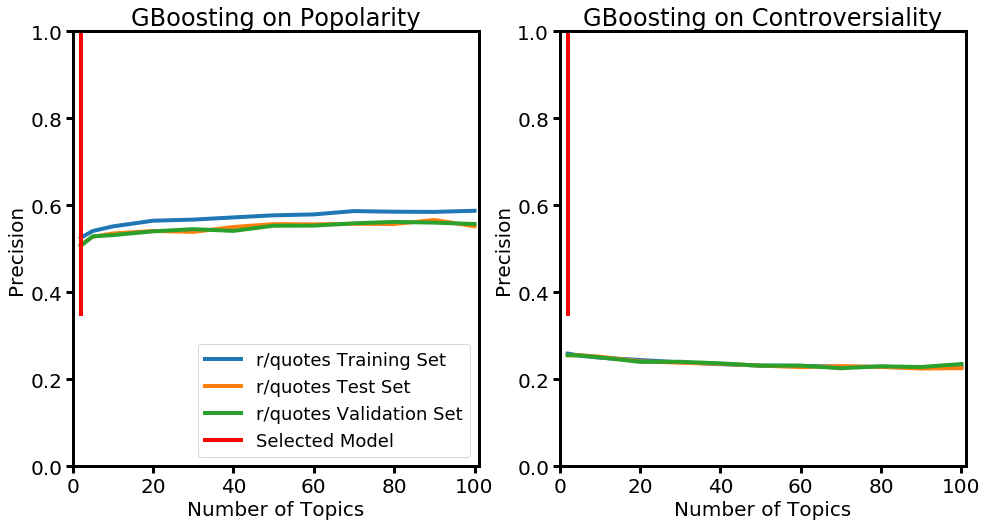

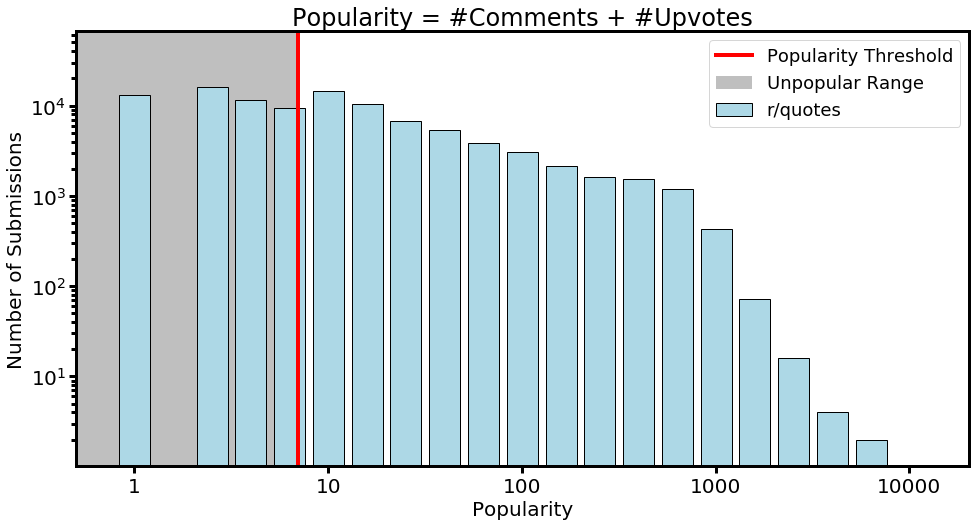

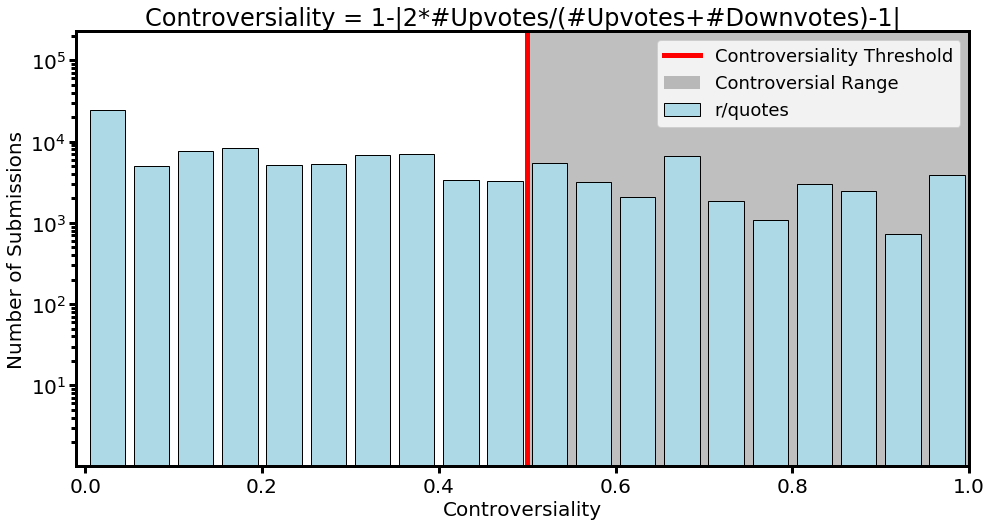

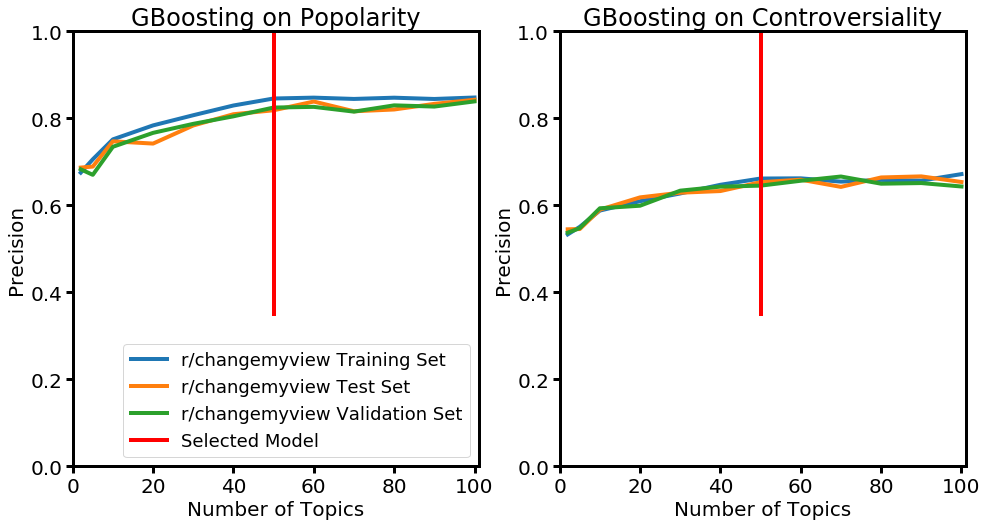

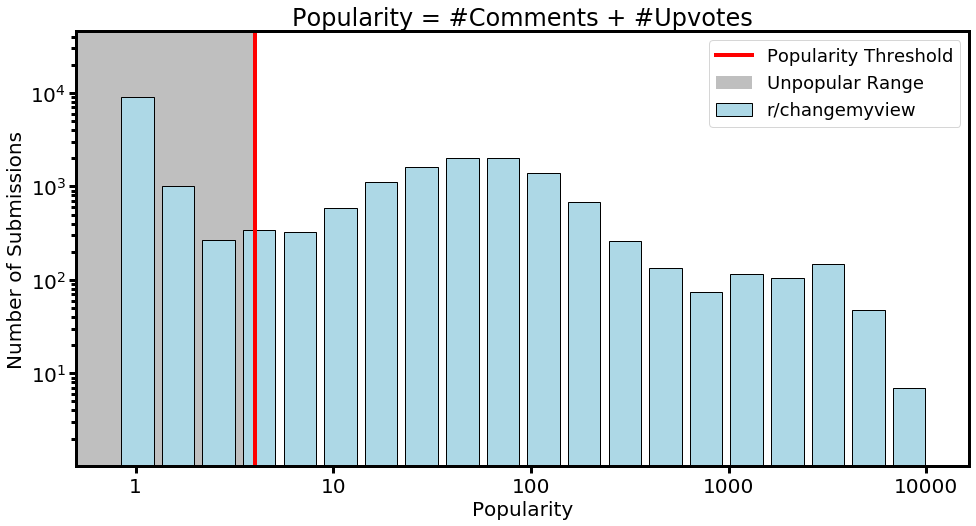

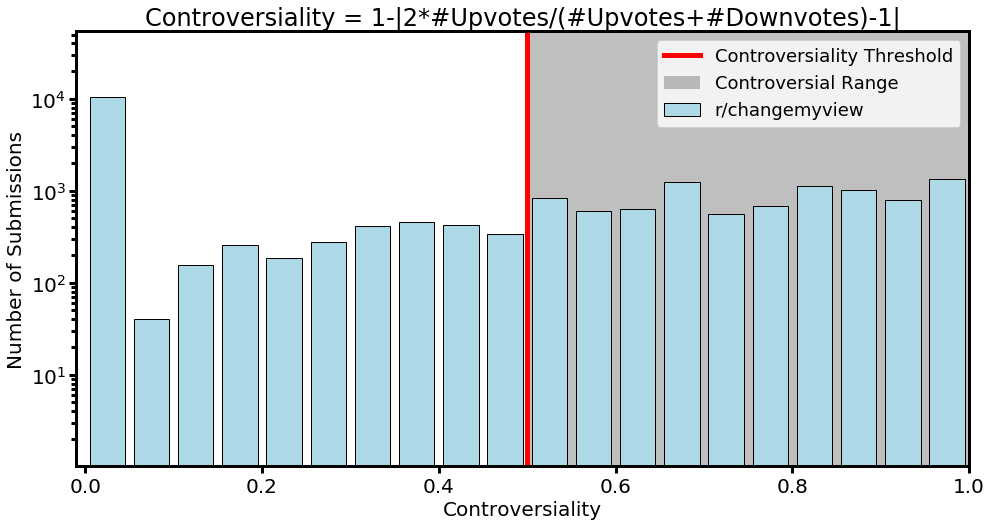

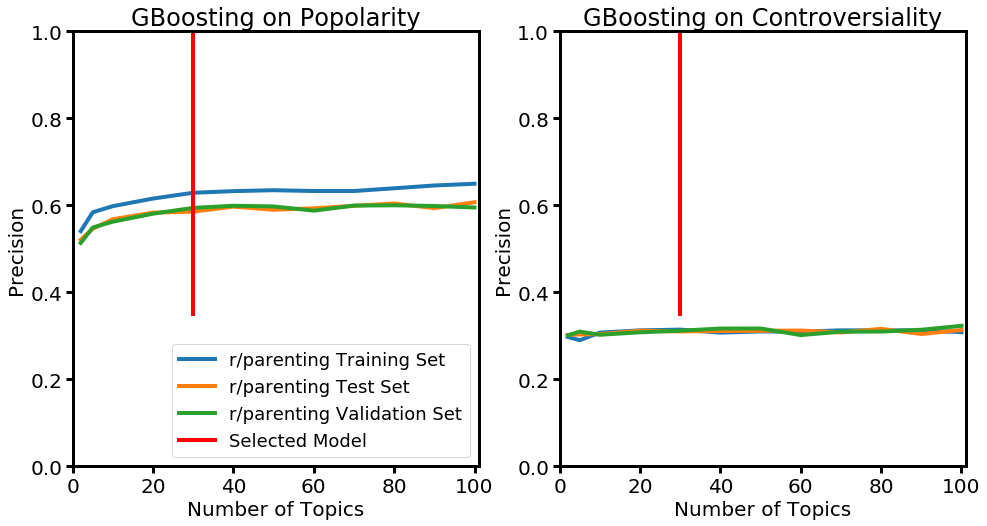

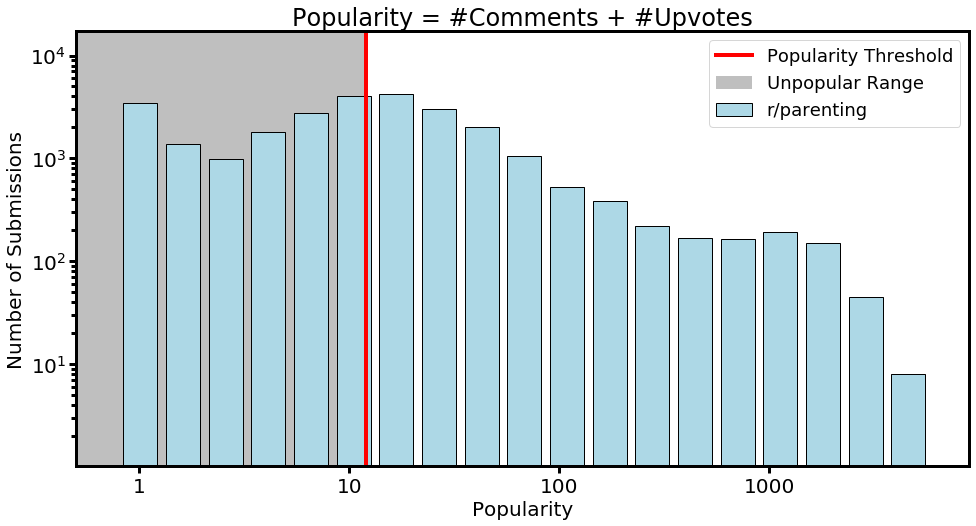

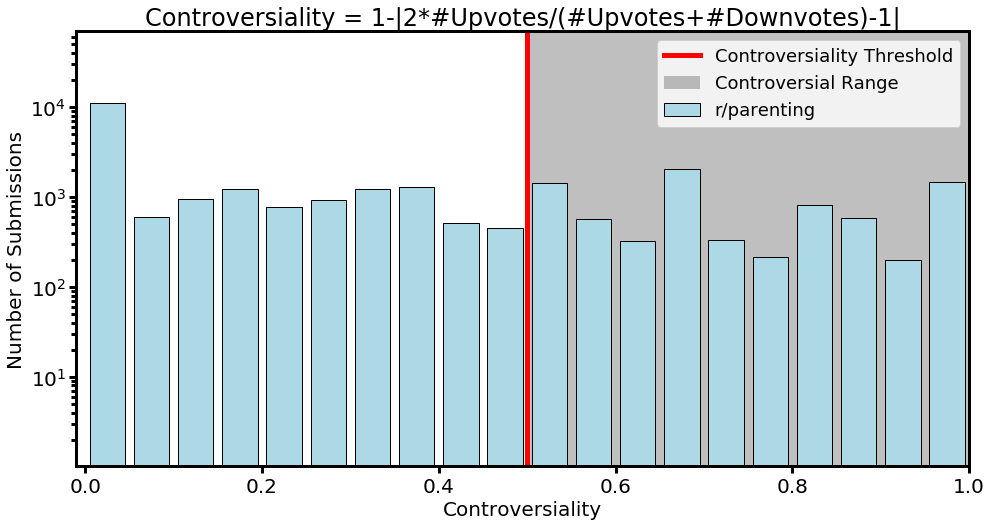

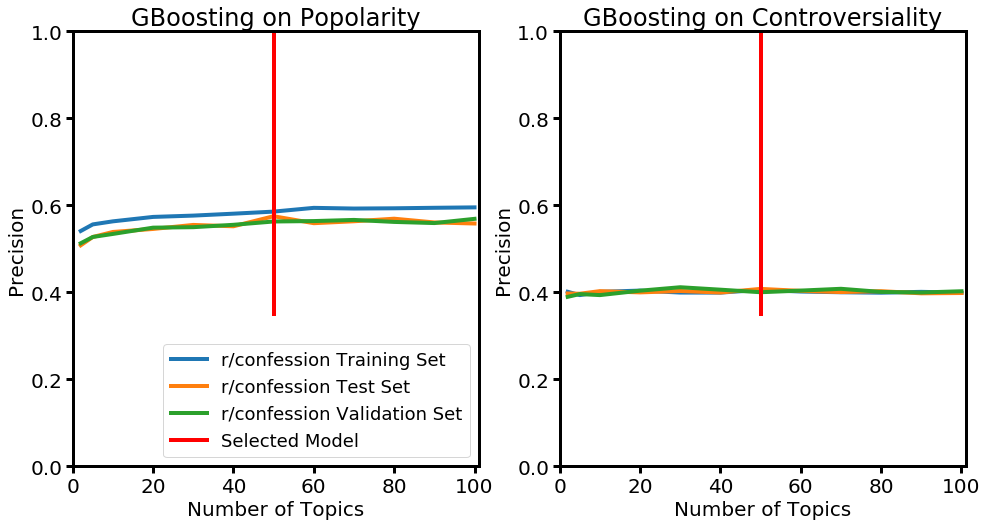

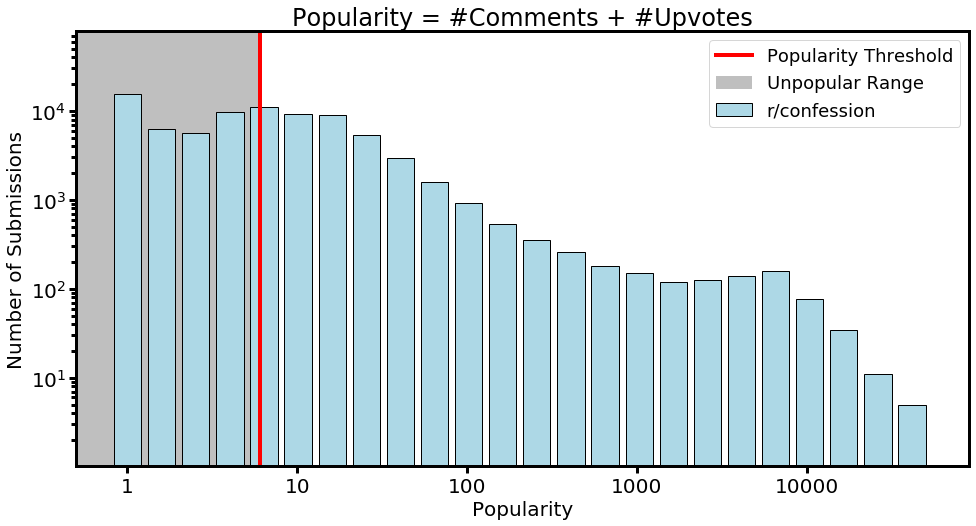

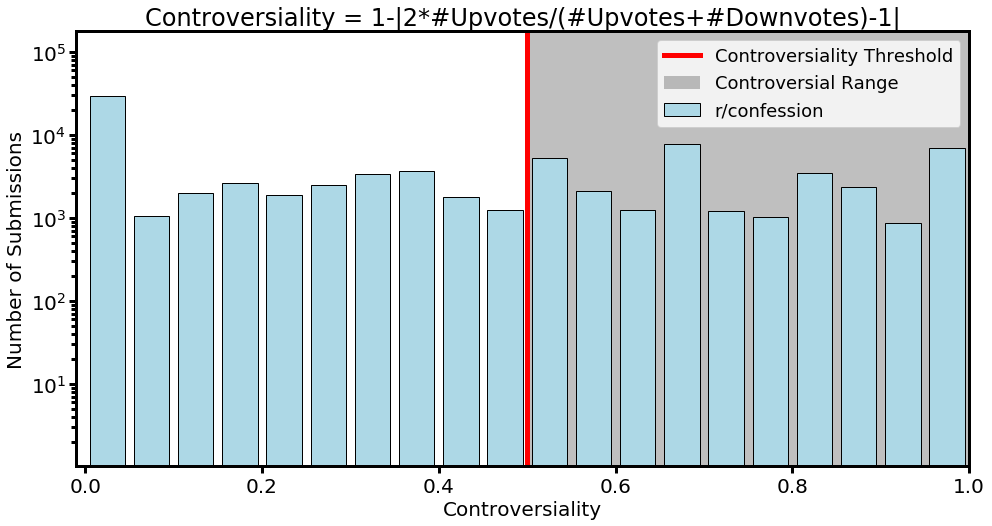

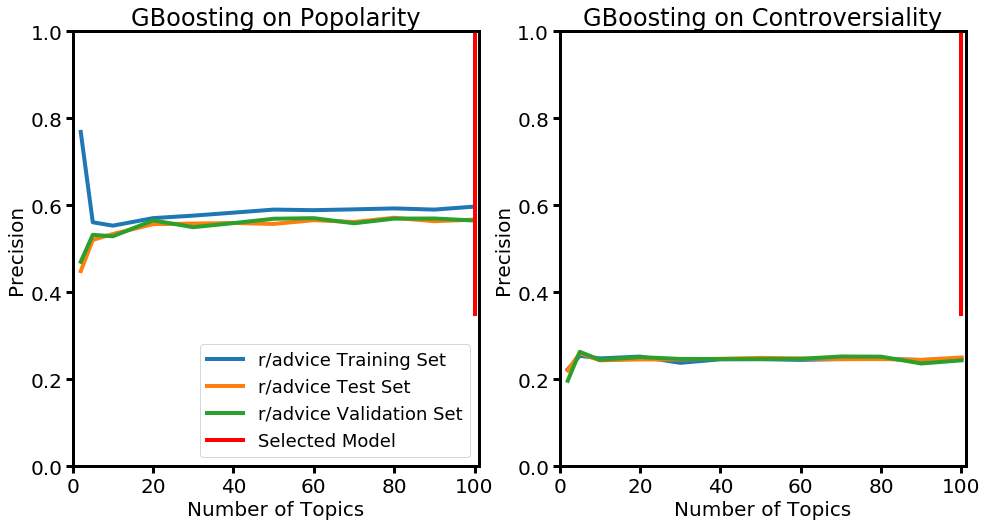

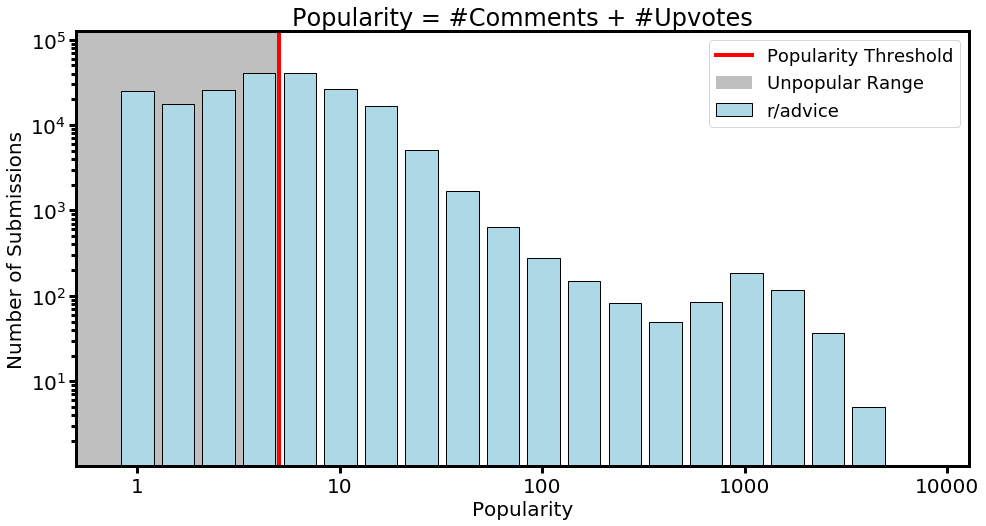

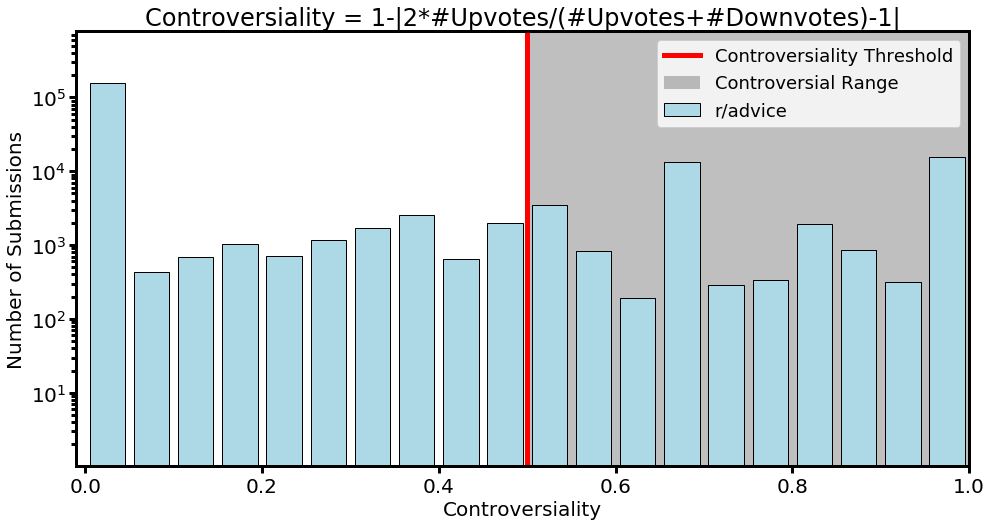

In [64]:
# Loop on all selected subreddits and create a model for them
subr_list = ["compsci", \
             "politicaldiscussion", \
             "history", \
             "quotes", \
             "changemyview", \
             "parenting" , \
             "confession", \
             "advice"
            ]

incr_thr = 5.0e-3
diff_thr = 1.0e3

for subr in subr_list:
    df = load_subr(subr)
    success = optimal_model(subr,df,incr_thr,diff_thr)